In [1]:
"""
    a test script for box-shape free generation
"""

import os
import sys
import shutil
import numpy as np
import torch
import utils
import vis_utils_layout as vis_utils
from data_layout import LayoutDataset, Tree
import model_layout as model

sys.setrecursionlimit(5000) # this code uses recursion a lot for code simplicity

# number of shapes to generate
num_gen = 500

path = 'magazine_2K_256'
cheakpoint = ''

# load train config
conf = torch.load(path + '/conf.pth')

# load object category information
Tree.load_category_info(conf.category)

# set up device
conf.device = 'cuda:0'
device = torch.device(conf.device)
print(f'Using device: {conf.device}')

# check if eval results already exist. If so, delete it. 
out_dir = path + '/freely_generated_shapes'
if os.path.exists(out_dir):
    # response = input('result directory %s exists, overwrite? (y/n) ' % out_dir)
    # if response != 'y':
    #     sys.exit()
    shutil.rmtree(out_dir)

# create a new directory to store eval results
os.mkdir(out_dir)

# create models
decoder = model.RecursiveDecoder(conf)

# load the pretrained models
print('Loading ckpt pretrained_decoder.pth')
data_to_restore = torch.load('./' + path + '/ckpts/' + cheakpoint + 'net_decoder.pth')
decoder.load_state_dict(data_to_restore, strict=True)
print('DONE\n')

# send to device
decoder.to(device)

# set models to evaluation mode
decoder.eval()

Using device: cuda:0
Loading ckpt pretrained_decoder.pth
DONE



RecursiveDecoder(
  (box_decoder): BoxDecoder(
    (xy): Linear(in_features=256, out_features=2, bias=True)
    (size): Linear(in_features=256, out_features=2, bias=True)
  )
  (sem_decoder): SemDecoder(
    (decoder): Linear(in_features=256, out_features=10, bias=True)
  )
  (leaf_decoder): LeafDecoder(
    (decoder): Linear(in_features=256, out_features=256, bias=True)
  )
  (vertical_decoder): BranchDecoder(
    (mlp_parent_1): Linear(in_features=256, out_features=1280, bias=True)
    (mlp_parent_2): Linear(in_features=1280, out_features=1280, bias=True)
    (mlp_exists): Linear(in_features=256, out_features=1, bias=True)
    (mlp_arrange): Linear(in_features=256, out_features=20, bias=True)
    (mlp_sem): Linear(in_features=256, out_features=10, bias=True)
    (mlp_child): Linear(in_features=256, out_features=256, bias=True)
  )
  (horizontal_decoder): BranchDecoder(
    (mlp_parent_1): Linear(in_features=256, out_features=1280, bias=True)
    (mlp_parent_2): Linear(in_features=128

In [12]:
code = torch.randn(1, conf.feature_size).cuda()
code.shape

torch.Size([1, 256])

In [13]:
code = torch.randn(1, conf.feature_size).cuda()
obj = decoder.decode_structure(z=code, max_depth=conf.max_tree_depth)
obj.get_arrbox()

In [14]:
obj.root.children[0].children[0].absbox

tensor([[0.0034, 0.0051, 0.4923, 0.3694]])

In [15]:
obj.root.children[0].children[1].box

tensor([[1.8483e-06, 8.1172e-05, 9.9999e-01, 1.8339e-01]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)

In [16]:
print(obj)

0 horizontal_branch    {0} 2 Box(tensor([[0.0034, 0.0051, 0.6030, 0.8405]], device='cuda:0',
       grad_fn=<SigmoidBackward0>))
  ├0 vertical_branch    {0} 1 Box(tensor([[0.0034, 0.0051, 0.4923, 0.8405]]))
  |  ├0 text [LEAF] {0} 4 Box(tensor([[0.0034, 0.0051, 0.4923, 0.3694]]))
  |  ├1 title [LEAF] {0} 6 Box(tensor([[0.0034, 0.3746, 0.4923, 0.1834]]))
  |  ├2 text [LEAF] {0} 4 Box(tensor([[0.0034, 0.5640, 0.4923, 0.4335]]))
  |  ├3 image [LEAF] {0} 3 Box(tensor([[0.0034, 1.0188, 0.4923, 0.3253]]))
  ├1 vertical_branch    {0} 1 Box(tensor([[0.4958, 0.0051, 0.4854, 0.8405]]))
  |  ├0 text [LEAF] {0} 4 Box(tensor([[0.4958, 0.0051, 0.4854, 0.4616]]))
  |  ├1 title [LEAF] {0} 6 Box(tensor([[0.4958, 0.4667, 0.4854, 0.1089]]))
  |  ├2 text [LEAF] {0} 4 Box(tensor([[0.4958, 0.5755, 0.4854, 0.4487]]))



In [18]:
obj.root.children[1].box

tensor([[9.3725e-05, 1.5694e-05, 4.8540e-01, 9.9970e-01]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)

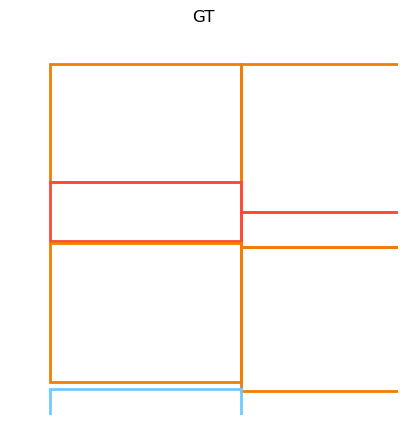

In [19]:
vis_utils.draw_partnet_objects(objects=[obj], object_names=['GT'],
                     figsize=(5, 5), leafs_only=True,
                     sem_colors_filename='./part_colors_magazine.txt')

In [2]:
num_gen = 500

out_dir = path + '/freely_generated_shapes'
if os.path.exists(out_dir):
    # response = input('result directory %s exists, overwrite? (y/n) ' % out_dir)
    # if response != 'y':
    #     sys.exit()
    shutil.rmtree(out_dir)

os.mkdir(out_dir)

# generate shapes
with torch.no_grad():
    for i in range(num_gen):
        print(f'Generating {i}/{num_gen} ...')

        # get a Gaussian noise
        code = torch.randn(1, conf.feature_size).cuda()
        
        # infer through the model to get the generated hierarchy
        # set maximal tree depth to conf.max_tree_depth
        obj_arr = decoder.decode_structure(z=code, max_depth=conf.max_tree_depth)
        obj_rel = decoder.decode_structure(z=code, max_depth=conf.max_tree_depth)
        obj_abs = decoder.decode_structure(z=code, max_depth=conf.max_tree_depth)

        obj_arr.get_arrbox()
        # obj_rel.get_relbox()
        # obj_abs.get_absbox()
        
        # output the hierarchy
        with open(os.path.join(out_dir, 'rand_gen_%03d.txt'%i), 'w') as fout:
            fout.write(str(obj_arr)+'\n\n')

        # output the assembled box-shape
        vis_utils.draw_partnet_objects([obj_arr],\
                object_names=['GENERATION'], \
                figsize=(5, 6), out_fn=os.path.join(out_dir, 'rand_gen_%03d.png'%i),\
                leafs_only=True,sem_colors_filename='./part_colors_magazine.txt')
        
        vis_utils.draw_partnet_objects([obj_arr],\
                object_names=['GENERATION'], \
                figsize=(5, 6), out_fn=os.path.join(out_dir, 'rand_gen_%03d.svg'%i),\
                leafs_only=True,sem_colors_filename='./part_colors_magazine.txt')


Generating 0/500 ...
Generating 1/500 ...
Generating 2/500 ...
Generating 3/500 ...
Generating 4/500 ...
Generating 5/500 ...
Generating 6/500 ...
Generating 7/500 ...
Generating 8/500 ...
Generating 9/500 ...
Generating 10/500 ...
Generating 11/500 ...
Generating 12/500 ...
Generating 13/500 ...
Generating 14/500 ...
Generating 15/500 ...
Generating 16/500 ...
Generating 17/500 ...
Generating 18/500 ...
Generating 19/500 ...
Generating 20/500 ...
Generating 21/500 ...
Generating 22/500 ...
Generating 23/500 ...
Generating 24/500 ...
Generating 25/500 ...
Generating 26/500 ...
Generating 27/500 ...
Generating 28/500 ...
Generating 29/500 ...
Generating 30/500 ...
Generating 31/500 ...
Generating 32/500 ...
Generating 33/500 ...
Generating 34/500 ...
Generating 35/500 ...
Generating 36/500 ...
Generating 37/500 ...
Generating 38/500 ...
Generating 39/500 ...
Generating 40/500 ...
Generating 41/500 ...
Generating 42/500 ...
Generating 43/500 ...
Generating 44/500 ...
Generating 45/500 ..

: 